In [1]:
#Import necessary libraries
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler 
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

from numpy import sqrt
from numpy import argmax

target     1.000000
mfccs4     0.179245
mfccs8     0.177236
mfccs11    0.127543
mfccs5     0.126474
mfccs2     0.120912
mfccs3     0.106872
mfccs7     0.088154
mfccs12    0.044737
mfccs1     0.039638
mfccs6     0.017535
mfccs9     0.010911
mfccs10   -0.084775
mfccs0    -0.370577
Name: target, dtype: float64

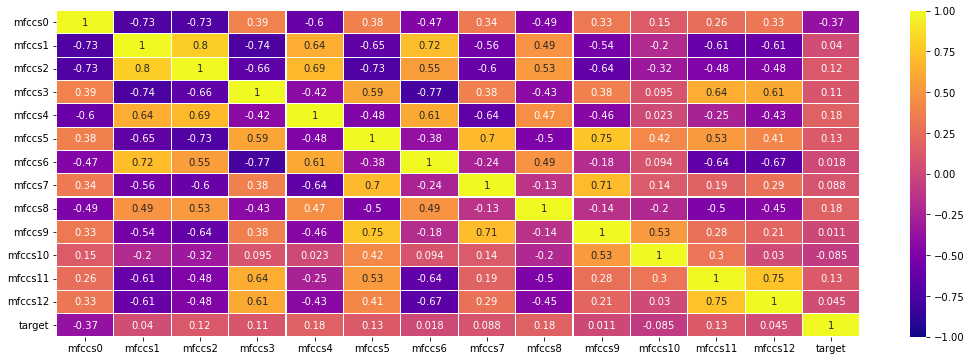

In [2]:
#Read and clean data
df = pd.read_csv('./6_dB_all/df_6dB_pump_fe_ta_imb.csv')
df.drop(['Unnamed: 0'],axis = 1, inplace = True)
df = df.drop(df.iloc[:,13:-1], axis=1)

#EDA
correlation = df.corr()
plt.figure(figsize=(18, 6))
sns.heatmap(correlation, annot=True, linewidths=0.1, vmin=-1, cmap="plasma")
correlation['target'].sort_values(ascending=False)

In [3]:
#Define features and the target
X = df.drop(['target'],axis=1)
y = df.target

# Normalise X
from sklearn import preprocessing

x = X.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
X = pd.DataFrame(x_scaled)

In [4]:
# Extract principal components (main dimensions of variation) using PCA, 
from sklearn.decomposition import PCA
pca = PCA(n_components = 5)
pca.fit(X)
X_pca = pca.transform(X)
X = pd.DataFrame(X_pca)

In [5]:
#split training and test sets, train_ratio = 0.70, validation_ratio = 0.15, test_ratio = 0.10

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=42,shuffle=True)

X_test,X_val,y_test,y_val = train_test_split(X_test,y_test,test_size=0.5,random_state=42,shuffle=True)

#models
model = RandomForestClassifier(n_estimators= 100, class_weight='balanced')

#Train the model
model.fit(X_train,y_train)


RandomForestClassifier(class_weight='balanced')

Best Threshold=0.870000, G-Mean=0.935


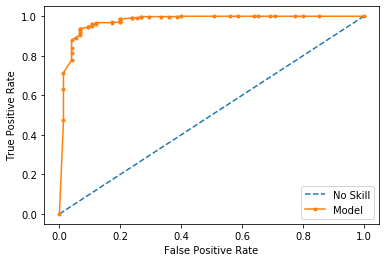

In [6]:
# ROC curve

'''Reference: https://machinelearningmastery.com/threshold-moving-for-imbalanced-classification/'''

# predict probabilities
lr_probs = model.predict_proba(X_test)

# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]

# calculate roc curves
fpr, tpr, thresholds = roc_curve(y_test, lr_probs)

# calculate the g-mean for each threshold
gmeans = np.sqrt(tpr * (1-fpr))
# locate the index of the largest g-mean
ix = argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))

# plot the roc curve for the model
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker='.', label='Model')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
# show the plot
plt.show()

In [7]:
#Predict
y_pred = model.predict(X_test)

# Test results
confusion_matrix(y_test,y_pred)
pd.crosstab(y_test, y_pred, rownames = ['Actual'], colnames =['Predicted'], margins = True)

Predicted,0,1,All
Actual,,,
0,53,22,75
1,1,555,556
All,54,577,631


In [9]:
#Predict
y_val_pred = model.predict(X_val)
# Test results
confusion_matrix(y_val,y_val_pred)
pd.crosstab(y_val, y_val_pred, rownames = ['Actual'], colnames =['Predicted'], margins = True)

Predicted,0,1,All
Actual,,,
0,45,19,64
1,1,566,567
All,46,585,631


In [ ]:
print('Training model report')
print(classification_report(y_train, y_train))
print('Testing model report')
print(classification_report(y_test, y_pred))
print('Validating model report')
print(classification_report(y_val, y_val_pred))

In [ ]:
#feature importance

importances = rfc.feature_importances_
std = np.std([tree.feature_importances_ for tree in rfc.estimators_], axis=0)

rfc_importances = pd.Series(importances)#, index=feature_names)

fig, ax = plt.subplots()
rfc_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()